In [1]:
from model import Network
from data import load_cifar10_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from metrics import lpips, psnr

# TODO: for exact reproducibility the seed should be set after the network initialization

# reproducibility
random_seed = 2024

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)

In [2]:
# load to model
model_config = './model_config/fc2_cocktail_party_cifar10_instance.json'
checkpoint_path = './checkpoints/122123_fc2_cocktail_party_cifar10_pretraining_wout_bias_wout_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
batch_size = 4
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([256, 3072]), torch.Size([10, 256])]


In [4]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [5]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 1, 1, 1)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 2.2794291973114014
loss: 1.0093843936920166
loss: 1.0001440048217773
loss: 1.00032377243042
loss: 1.0002055168151855
loss: 1.0003554821014404
loss: 1.0003130435943604
loss: 1.0002573728561401
loss: 1.0003101825714111
loss: 1.0002702474594116
loss: 1.0002155303955078
loss: 1.0002609491348267
loss: 1.0003167390823364
loss: 1.0003514289855957
loss: 1.0003222227096558
loss: 1.000275731086731
loss: 1.0002224445343018
loss: 1.000285267829895
loss: 1.000245451927185
loss: 1.000269889831543
loss: 1.0003032684326172
loss: 1.0002193450927734
loss: 1.0002351999282837
loss: 1.0002580881118774
loss: 1.0002899169921875
loss: 1.00028395652771


In [6]:
unmixing_matrix = unmixing_matrix.detach().to('cpu')
whitened_gradient = whitened_gradient.detach().to('cpu')

## PSNR Values

In [7]:
with torch.no_grad():
    psnr_match, psnr_is_positive, mean_psnr = psnr(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [8]:
psnr_match

[tensor([0, 2]), tensor([3, 0]), tensor([1, 3]), tensor([2, 1])]

In [9]:
mean_psnr

8.210582852363586

In [10]:
psnr_is_positive

[False, False, True, False]

## LPIPS

In [11]:
with torch.no_grad():
    lpips_match, lpips_is_positive, mean_lpips = lpips(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [12]:
lpips_match

[tensor([2, 1]), tensor([3, 3]), tensor([0, 0]), tensor([1, 2])]

In [13]:
mean_lpips

0.16022763215005398

In [14]:
lpips_is_positive

[True, False, True, True]

## Estimated images

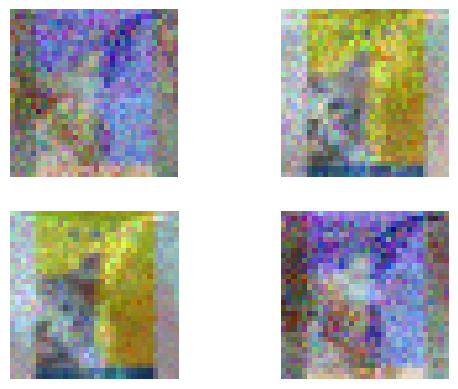

In [15]:
with torch.no_grad():
    estimated_img = (unmixing_matrix @ whitened_gradient)
    
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax, is_positive in zip(estimated_img, axes.flatten(), lpips_is_positive):
        estimate_coeff = 1 if is_positive else -1
        img = colors.Normalize()(np.asarray(estimate_coeff * estimate).reshape(3, 32, 32).transpose(1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

## Original images

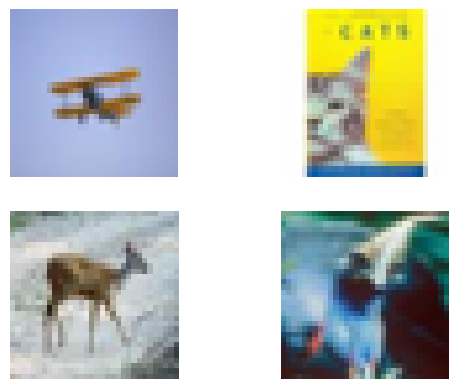

In [16]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 2)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()